In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git config --global user.email "Vfhbz_bcfrdf@inbox.ru"

In [ ]:
!git config --global user.name "Isakova74"

In [ ]:
%cd ./drive/MyDrive/2023-Isakova-TimeSeriesCourse

[Errno 2] No such file or directory: './drive/MyDrive/2023-Isakova-TimeSeriesCourse'
/content/drive/MyDrive/2023-Isakova-TimeSeriesCourse


In [ ]:
!git add .

In [ ]:
!git commit -m "Задание 3"

[main 92ef320] Задание 3
 5 files changed, 28644 insertions(+), 2 deletions(-)
 rewrite practice/02_Similarity_search/02 Similarity search.ipynb (93%)
 rewrite practice/03_Discords/03 Discords.ipynb (85%)
 create mode 100644 practice/03_Discords/dataset/nyc_taxi.csv
 create mode 100644 practice/03_Discords/datasets/nyc_taxi.csv
 create mode 100644 practice/03_Discords/datasets/walk_run.txt


In [ ]:
!git push origin main

Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 2 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 871.35 KiB | 9.68 MiB/s, done.
Total 10 (delta 3), reused 1 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Isakova74/2023-Isakova-TimeSeriesCourse.git
   acd2d43..92ef320  main -> main


## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

In [1]:
!pip install scipy
!pip install scikit-learn

##### *Краткое описание*

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра.
Анализируемый временной ряд, описывает две активности человека - бег и шг
.


In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#fixme: Путь
dataset_dir_path = Path('datasets')/'/content/drive/MyDrive/2023-Isakova-TimeSeriesCourse/practice/03_Discords/dataset/walk_run.txt'
#data_path = dataset_dir_path/'walk_run.txt'
walk_run = np.loadtxt(dataset_dir_path)[3000:4000]
data = walk_run
size_sub = 50

In [23]:
#data

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

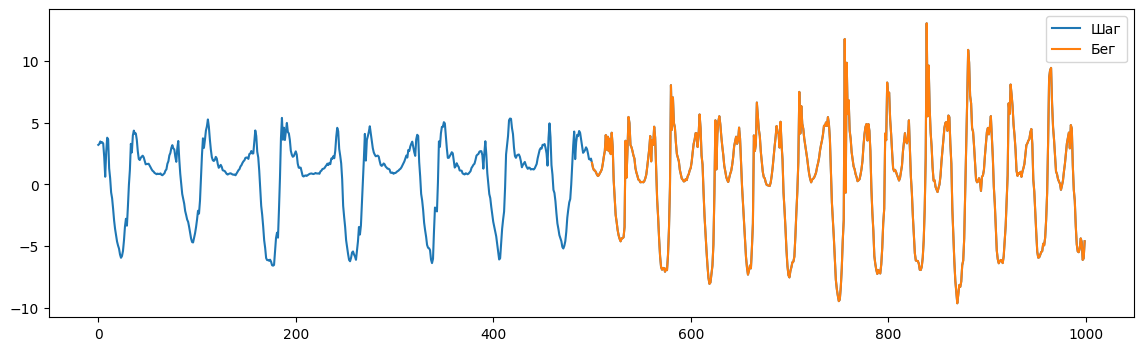

In [4]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

In [5]:
result={}
times={}

##### 3.1.2 Реализация перебором

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализация перебором.
Вам необходимо добавить код для сбора времени обработки данных.

In [7]:
!pip install saxpy

In [8]:
import time

In [6]:
from saxpy.discord import find_discords_brute_force
start = time()
discords_brute_force= np.stack(find_discords_brute_force(data[:], 50, 5))
end = time()
result['brute_force'] = discords_brute_force
times['brute_force'] = end-start


##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [ ]:
# INSERT YOUR CODE

In [7]:
#Implements HOT-SAX.
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import sax_via_window
from saxpy.distance import euclidean


def find_discords_hotsax(series, win_size=100, num_discords=2, alphabet_size=3,
                         paa_size=3, znorm_threshold=0.01, sax_type='unidim'):
    """Обнаружение разногласий на основе HOT-SAX."""
    discords = list()

    global_registry = set()

    # Z-нормализованные версии для каждой подпоследовательности.
    znorms = np.array([znorm(series[pos: pos + win_size], znorm_threshold) for pos in range(len(series) - win_size + 1)])

    # Слова SAX для каждой подпоследовательности.
    sax_data = sax_via_window(series, win_size=win_size, paa_size=paa_size, alphabet_size=alphabet_size,
                              nr_strategy=None, znorm_threshold=0.01, sax_type=sax_type)

    """[2.0] построить «волшебный» массив"""
    magic_array = list()
    for k, v in sax_data.items():
        magic_array.append((k, len(v)))

    """[2.1] отсортировать по возрастанию по количеству вхожденийs"""
    magic_array = sorted(magic_array, key=lambda tup: tup[1])

    while len(discords) < num_discords:

        best_discord = find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms)

        if -1 == best_discord[0]:
            break

        discords.append(best_discord)

        mark_start = max(0, best_discord[0] - win_size + 1)
        mark_end = best_discord[0] + win_size

        for i in range(mark_start, mark_end):
            global_registry.add(i)

    return discords


def find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms):
    """Найдите лучший дискорд с помощью hotsax."""

    """[3.0] определить ключевые переменные"""
    best_so_far_position = -1
    best_so_far_distance = 0.

    distance_calls = 0

    visit_array = np.zeros(len(series), dtype=np.int)

    """[4.0] и мы прекращаем перебор записей магического массива"""
    for entry in magic_array:

        """[5.0] текущие слова SAX и количество других последовательностей, сопоставленных с тем же словом SAX."""
        curr_word = entry[0]
        occurrences = sax_data[curr_word]

        """[6.0] проходя по одним и тем же вхождениям слов, легче
        зафиксировать, возможно, небольшое значение расстояния, чтобы мы могли работать эффективно
        и т.д...."""
        for curr_pos in occurrences:

            if curr_pos in global_registry:
                continue

            """[7.0] нам не нужна перекрывающаяся подпоследовательность"""
            mark_start = curr_pos - win_size + 1
            mark_end = curr_pos + win_size
            visit_set = set(range(mark_start, mark_end))

            """[8.0] вот наша подпоследовательность, о которой идет речь"""
            cur_seq = znorms[curr_pos]

            """[9.0] давайте посмотрим, что такое расстояние NN"""
            nn_dist = np.inf
            do_random_search = True

            """[10.0] упорядочен по вхождениям, искать в первую очередь"""
            for next_pos in occurrences:

                """[11.0] пропустить плохое сообщение"""
                if next_pos in visit_set:
                    continue
                else:
                    visit_set.add(next_pos)

                """[12.0] расстояние, которое мы вычисляем"""

                dist = euclidean(cur_seq, znorms[next_pos])
                distance_calls += 1

                """[13.0] поддерживать книги в актуальном состоянии"""
                if dist < nn_dist:
                    nn_dist = dist
                if dist < best_so_far_distance:
                    do_random_search = False
                    break

            """[13.0] если не сломано выше,
            мы продолжим случайный поиск"""
            if do_random_search:
                """[14.0] построить этот массив случайных заказов на посещение"""
                curr_idx = 0
                for i in range(0, (len(series) - win_size + 1)):
                    if not(i in visit_set):
                        visit_array[curr_idx] = i
                        curr_idx += 1
                it_order = np.random.permutation(visit_array[0:curr_idx])
                curr_idx -= 1

                """[15.0] и пойти наугад"""
                while curr_idx >= 0:
                    rand_pos = it_order[curr_idx]
                    curr_idx -= 1

                    dist = euclidean(cur_seq, znorms[rand_pos])
                    distance_calls += 1

                    """[16.0] поддерживать книги в актуальном состоянии снова"""
                    if dist < nn_dist:
                        nn_dist = dist
                    if dist < best_so_far_distance:
                        nn_dist = dist
                        break

            """[17.0] и БОЛЬШИЕ книги"""
            if (nn_dist > best_so_far_distance) and (nn_dist < np.inf):
                best_so_far_distance = nn_dist
                best_so_far_position = curr_pos

    return best_so_far_position, best_so_far_distance

In [8]:
from saxpy.hotsax import find_discords_hotsax

start = time()
discords_hotsax = find_discords_hotsax(data[:], num_discords=5, win_size=size_sub)
end = time()
time_hotsax=end-start
print(end - start, '\n')
discords_hotsax

9.562551021575928 



[(477, 5.881009341683914),
 (412, 5.327043167878002),
 (195, 3.394266347302333),
 (577, 3.3555440274836608),
 (278, 3.10959388763498)]

##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы
   
Постройте графики для обоих алгоритмов и сравните полученные результаты. Сделайте выводы

In [ ]:
# INSERT YOUR CODE

In [9]:
from matplotlib.patches import Rectangle

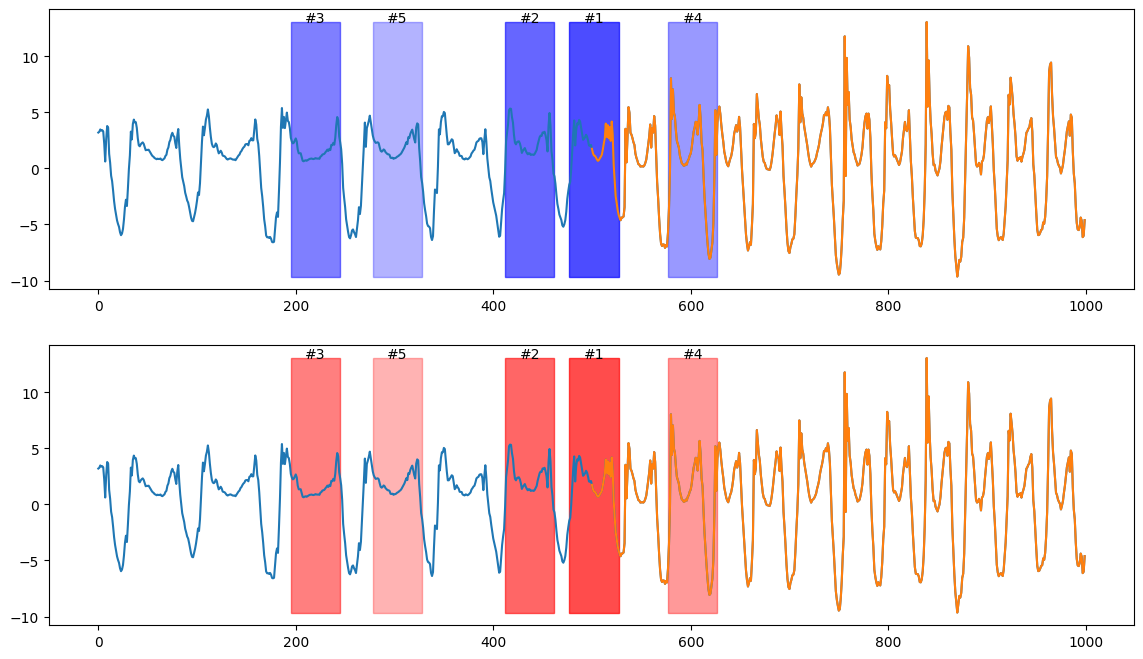

In [10]:
from matplotlib.patches import Rectangle
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.label = 'brute force'
ax2.label = 'hotsax'
mn, mx = min(data), max(data)

for i in range(len(discords_brute_force)):
    alpha = 1-(i+3)*0.1
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='blue', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(data[:], label='Шаг')
ax1.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

for i in range(len(discords_hotsax)):
    alpha = 1-(i+3)*0.1
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(data[:], label='Шаг')
ax2.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

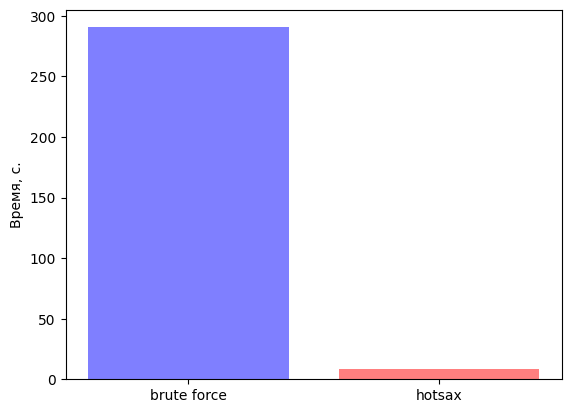

In [11]:
fig, ax = plt.subplots()
ax.bar(['brute force', 'hotsax'], [290.58384823799133, 8.51403546333313], color=['blue', 'red'], alpha=0.5)
ax.set_ylabel('Время, с.');

##### 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами.

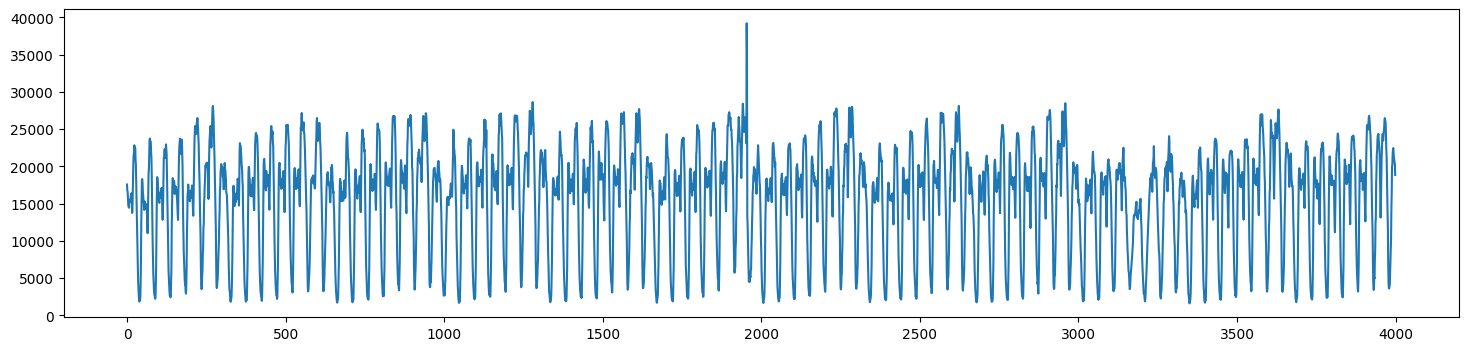

In [12]:
nyc_taxi = pd.read_csv('/content/drive/MyDrive/2023-Isakova-TimeSeriesCourse/practice/03_Discords/dataset/nyc_taxi.csv',index_col=0).values[4000:8000,0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

In [ ]:
# INSERT YOUR CODE

In [ ]:
start = time()
discords_brute_force = find_discords_brute_force(nyc_taxi[:], win_size=size_sub, num_discords=1)
end = time()
time_brute_1 = round(end-start)

In [ ]:
start_sax = time()
discords_hotsax = find_discords_hotsax(nyc_taxi[:], num_discords=5, win_size=size_sub) # 38 seconds
end_sax = time()
time_sax = round(end_sax-start_sax)

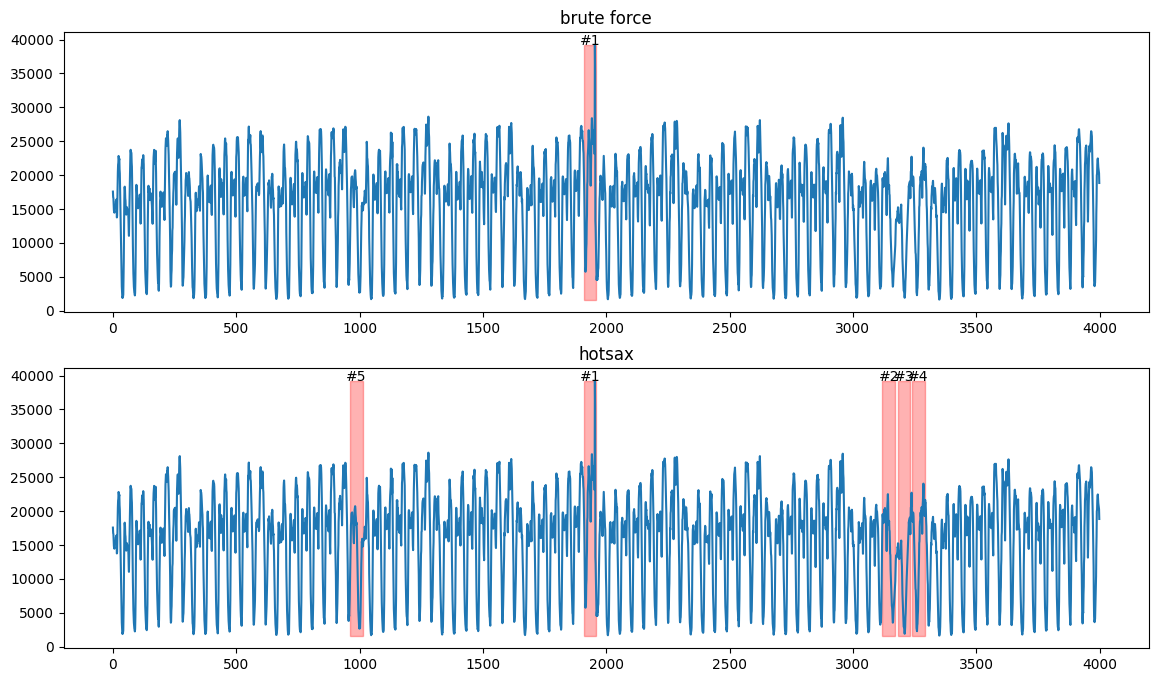

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.set_title('brute force')
ax2.set_title('hotsax')
mn, mx = min(nyc_taxi), max(nyc_taxi)

for i in range(len(discords_brute_force)):
    alpha = 0.3
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(nyc_taxi)

for i in range(len(discords_hotsax)):
    alpha = 0.3
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(nyc_taxi)

Вывод:

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [38]:
#!pip install stumpy

In [ ]:
!pip install stumpy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: stumpy
    Found existing installation: stumpy 1.12.0
    Uninstalling stumpy-1.12.0:
      Successfully uninstalled stumpy-1.12.0


In [ ]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump

In [39]:
import pandas as pd
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump
import numpy as np
import matplotlib.pyplot as plt
import math
import time


Диапазонный диссонанс – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога.

Таким образом при поиске основными параметрами данного алгоритма являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего сдаосе

Установим пока что эти параметры случайным образом.а.


In [40]:
!pip install modules

In [ ]:
from modules.drag import find_candidates, DRAG

ModuleNotFoundError: ignored

Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом DRAG (Discord Range Aware Gathering). Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.

In [ ]:
data = walk_run

In [45]:
#from modules.drag import find_candidates
#m = 100
#r = 4.7

ModuleNotFoundError: ignored

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек. Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [ ]:
m = 50
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат.

In [ ]:
m = 50
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
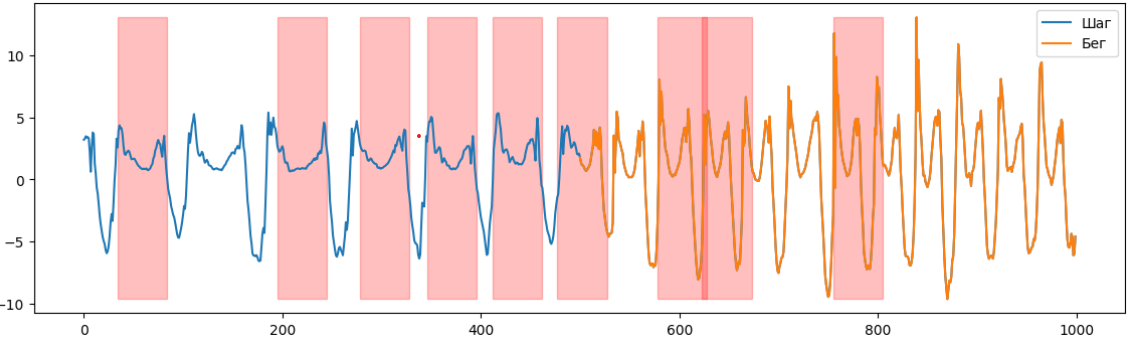

In [ ]:
# INSERT YOUR CODE

Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1.Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2.Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы вибраем из всего множества подпоследовательностей ряда такие, для которых растояния до правых ближайших соседей больше параметра $r$.

In [ ]:
#выбирем более реальное значение для порога
r = 3

In [ ]:
T, M_T, Σ_T = core.preprocess(data, m)
#формируем массив длинной равной длине  исходного ряда - m + 1,
#элемент массива является истинным,
#в том случае если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
#находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)

In [ ]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

Во время отбора кандидатов нам удалось выделить около 140 подпоследовательностей(около 14%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидем, что большая часть потенциальных диссонансов расположена в районе смены активности.
К сожалению присуствуют и ложные диссонасы, которые случаныйм образом попали в данный список.

In [ ]:
# INSERT YOUR CODE

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cand_index):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 14% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с числом $r$.


In [ ]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [ ]:
len(cands)/len(data)*100

Сформируйте график найденных диссонансов

In [ ]:
# INSERT YOUR CODE

NameError: ignored

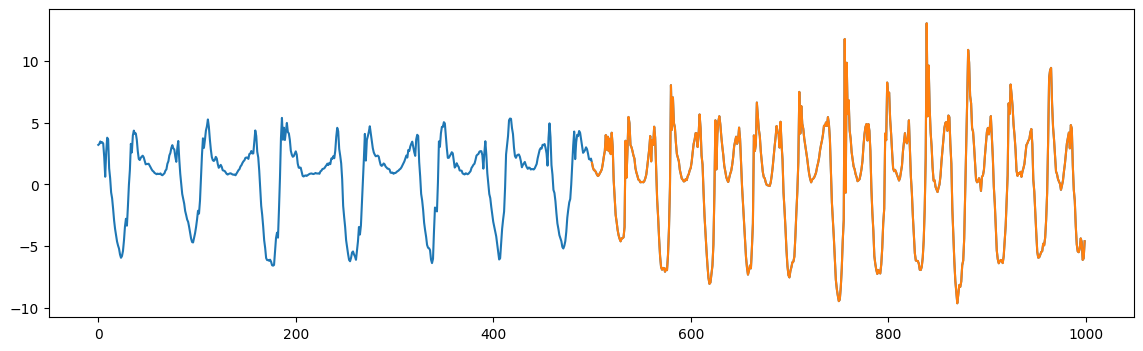

In [13]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cands):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


Нам удалось сократить число диссонансов до 7%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [ ]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

0.5

Сформируйте график найденных диссонансов

In [ ]:
# INSERT YOUR CODE

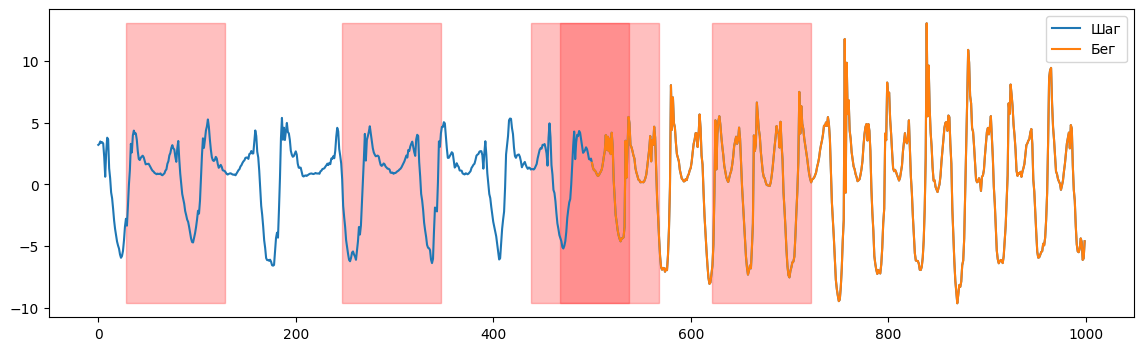

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(discords_idx):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.25))
plt.legend()


##### 3.2.3 Подбор параметров

Подберите параметры $m$ и $r$ таким образом, чтобы алгоритм обнаружил только те диссонасы, которые связаны со сменой активности.
Попробуйте несколько различных комбинаций $m$ и $r$. Сделайте вывод о том, как эти параметры влияют на качество работы модели.

In [ ]:
# INSERT YOUR CODE

#### **2.3 Поиск диссонансов с помощью алгоритма Merlin**

##### *Краткое описание*

##### 2.3.1 Загрузка и подготовка данных
fixme: добавить описание данных и саму выгрузку данных

##### 2.3.2 Merlin

Используя [реализацию]() найдите топ 5 диссонансов ряда.
Произведите замер времени работы. (уточнить про реализацию поиска соседей)

25

4

##### 2.3.3 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Графики времени работы
   
Постройте графики для моделей и сравните полученные результаты с алгоритмами из предыдущих пунктов.
Сделайте выводы